# Theoretical Foundations of Buffer Stock Saving
<p style="text-align: center;"><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></p>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/REMARK/master?filepath=REMARKs%2FBufferStockTheory%2FBufferStockTheory.ipynb)

[This notebook](https://github.com/econ-ark/REMARK/blob/master/REMARKs/BufferStockTheory/BufferStockTheory.ipynb) uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to describe the main results and reproduce the figures in the paper [Theoretical Foundations of Buffer Stock Saving](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory) <cite data-cite="6202365/8AH9AXN2"></cite>


If you are not familiar with the HARK toolkit, you may wish to browse the ["Gentle Introduction to HARK"](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=Gentle-Intro-To-HARK.ipynb) before continuing (since you are viewing this document, you presumably know a bit about [Jupyter Notebooks](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/)).

For instructions on how to install the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit on your computer, please refer to the [QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md). 

The main HARK tool used here is $\texttt{ConsIndShockModel.py}$, in which agents have CRRA utility and face idiosyncratic shocks to permanent and transitory income.  For an introduction to this module, see the [ConsIndShockModel.ipynb](https://econ-ark.org/notebooks) notebook at the [Econ-ARK](https://econ-ark.org) website.



In [4]:
# Install libraries
from IPython.utils import io

with io.capture_output() as captured:
    !pip install econ-ark==0.10.0.dev2
    !pip install matplotlib
    !pip install numpy
    !pip install scipy
    !pip install ipywidgets
    !pip install jupyter_contrib_nbextensions
    !jupyter contrib nbextension install
    !jupyter nbextension enable codefolding/main
    !pip install cite2c
    !python -m cite2c.install

    !python -c "import matplotlib as mpl; mpl.use('Agg'); import pylab as plt; fig, ax = plt.subplots(); fig.savefig('test.png')"
    !test -e test.png && rm test.png
    !apt-get update
    !apt-get install texlive texlive-latex-extra texlive-xetex dvipng

In [0]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [0]:
# This cell does some setup and imports generic tools used to produce the figures

Generator=False # Is this notebook the master or is it generated?
# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        elif str(type(get_ipython())) == "<class 'google.colab._shell.Shell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../../lib')) # REMARKs directory is two down from root 

from HARK.utilities import plotFuncsDer, plotFuncs
from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.ipynb")) # Find pathname to this file:
    Figures_HARK_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    Figures_HARK_dir = os.path.join(my_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(Figures_HARK_dir):
        os.makedirs(Figures_HARK_dir)

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

The paper defines and calibrates a small set of parameters:

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\Gamma}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\newcommand{\IncUnemp}{\mu}\IncUnemp$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\newcommand{\PermShkStd}{\sigma_\psi}\PermShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\newcommand{\TranShkStd}{\sigma_\theta}\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' (net worth plus current income) $M_{t}$, end-of-period assets $A_{t}$ will be the amount remaining after consumption of $C_{t}$.  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=& M_{t}-C_{t}   \\
\end{eqnarray}

The consumer's permanent noncapital income $P$ grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}

and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, the paper shows that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}


In [0]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.03
Rfree      = 1.04
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.005
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

## Convergence of the Consumption Rules

[The paper's first figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Convergence-of-the-Consumption-Rules) depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and earlier periods under the baseline parameter values given above.

In [0]:
# Create a buffer stock consumer instance by passing the dictionary to the class.
baseEx = IndShockConsumerType(**base_params)
baseEx.cycles = 100   # Make this type have a finite horizon (Set T = 100)

baseEx.solve()        # Solve the model
baseEx.unpackcFunc()  # Make the consumption function easily accessible

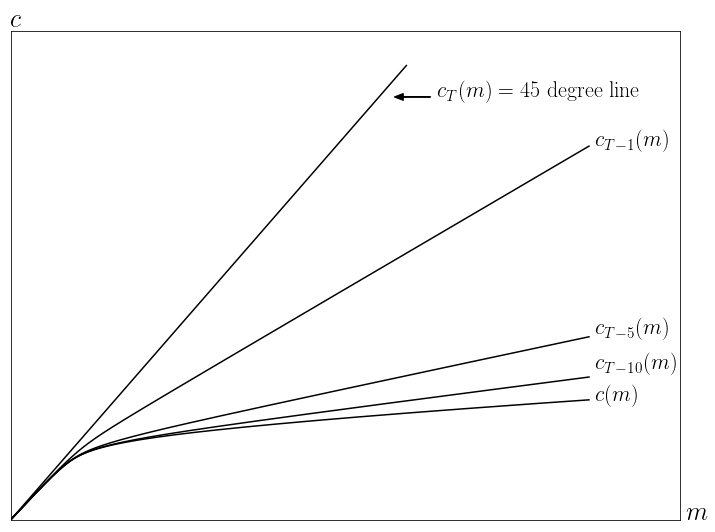

In [9]:
# Plot the different periods' consumption rules.


m1 = np.linspace(0,9.5,1000) # Set the plot range of m
m2 = np.linspace(0,6.5,500)
c_m  = baseEx.cFunc[0](m1)   # c_m can be used to define the limiting inﬁnite-horizon consumption rule here
c_t1 = baseEx.cFunc[-2](m1) # c_t1 defines the second-to-last period consumption rule
c_t5 = baseEx.cFunc[-6](m1) # c_t5 defines the T-5 period consumption rule
c_t10 = baseEx.cFunc[-11](m1)  # c_t10 defines the T-10 period consumption rule
c_t0 = m2                            # c_t0 defines the last period consumption rule
plt.figure(figsize = (12,9))
plt.plot(m1,c_m,color="black")
plt.plot(m1,c_t1,color="black")
plt.plot(m1,c_t5,color="black")
plt.plot(m1,c_t10,color="black")
plt.plot(m2,c_t0,color="black")
plt.xlim(0,11)
plt.ylim(0,7)
plt.text(7,6,r'$c_{T}(m) = 45$ degree line',fontsize = 22,fontweight='bold')
plt.text(9.6,5.3,r'$c_{T-1}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.6,r'$c_{T-5}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.1,r'$c_{T-10}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,1.7,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.arrow(6.9,6.05,-0.6,0,head_width= 0.1,width=0.001,facecolor='black',length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,7.05,"$c$",fontsize = 26)
plt.text(11.1,0,"$m$",fontsize = 26)
# Save the figures in several formats
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

## Factors and Conditions

### [The Finite Human Wealth Condition](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Human-Wealth)

Human wealth for a perfect foresight consumer is defined as the present discounted value of future income:

\begin{eqnarray}
H_{t} & = & \mathbb{E}[P_{t} + R^{-1} P_{t+1} + R^{2} P_{t+2} ... ] \\ 
      & = & P_{t}\mathbb{E}[1 + (\Gamma/R) + (\Gamma/R)^{2} ... ]
\end{eqnarray}
which is an infinite number if $\Gamma/R \geq 1$.  We say that the 'Finite Human Wealth Condition' (FHWC) holds if 
$0 \leq (\Gamma/R) \leq 1$.

### [Absolute Patience and the AIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AIC)

The paper defines an object which it calls the Absolute Patience Factor, equal to the ratio of $C_{t+1}/C_{t}$ for a perfect foresight consumer.  The Old English character <span style="font-size:larger;">"&#222;"</span> is used for this object in the paper, but <span style="font-size:larger;">"&#222;"</span> cannot currently be rendered conveniently in Jupyter notebooks, so we will substitute $\Phi$ here:

\begin{equation}
\Phi = (R \beta)^{1/\rho} 
\end{equation}

If $\Phi = 1$, a perfect foresight consumer will spend exactly the amount that can be sustained perpetually (given their current and future resources).  If $\Phi < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\Phi > 1$ consumption will grow over time.



### [Growth Patience and the GIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#GIC)

For a [perfect foresight consumer](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA), whether the ratio of consumption to the permanent component of income $P$ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income, which is measured by the "Perfect Foresight Growth Patience Factor":

\begin{eqnarray}
\Phi_{\Gamma} & = & \Phi/\Gamma
\end{eqnarray}
and whether the ratio is falling or rising over time depends on whether $\Phi_{\Gamma}$ is below or above 1.

An analogous condition can be defined when there is uncertainty about permanent income.  Defining $\tilde{\Gamma} = (\mathbb{E}[\psi^{-1}])^{-1}\Gamma$, the 'Growth Impatience Condition' (GIC) is that 
\begin{eqnarray}
  \Phi/\tilde{\Gamma} & < & 1
\end{eqnarray}

### [The Finite Value of Autarky Condition (FVAC)](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value)

The paper [shows](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Autarky-Value) that a consumer who planned to spend his permanent income $\{ p_{t}, p_{t+1}, ...\} $ in every period would have value defined by

\begin{equation}
v_{t}^{\text{autarky}} = u(p_{t})\left(\frac{1}{1-\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}]}\right)
\end{equation}

and defines the 'Finite Value of Autarky Condition' as the requirement that the denominator of this expression be a positive finite number:

\begin{equation}
\beta \Gamma^{1-\rho} \mathbb{E}[\psi^{1-\rho}] < 1
\end{equation}

### [The Weak Return Impatience Condition (WRIC)](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#WRIC)

The 'Return Impatience Condition' $\Phi/R < 1$ has long been understood to be required for the perfect foresight model to have a nondegenerate solution (when $\rho=1$, this reduces to $\beta < R$).  If the RIC does not hold, the consumer is so patient that the optimal consumption function approaches zero as the horizon extends.

When the probability of unemployment is $\wp$, the paper articulates an analogous (but weaker) condition:

\begin{eqnarray}
 \wp^{1/\rho} \Phi/R & < & 1
\end{eqnarray}

# Key Results

## [Nondegenerate Solution Requires FVAC and WRIC](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution)

A main result of the paper is that the conditions required for the model to have a nondegenerate solution ($0 < c(m) < \infty$ for feasible $m$) are that the Finite Value of Autarky (FVAC) and Weak Return Impatience Condition (WRAC) hold.

## [Natural Borrowing Constraint limits to Artificial Borrowing Constraint](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Liquidity-Constrained-Solution-as-a-Limit)

Defining $\chi(\wp)$ as the consumption function associated with any particular value of $\wp$, and defining $\hat{\chi}$ as the consumption function that would apply in the absence of the zero-income shocks but in the presence of an 'artificial' borrowing constraint requiring $a \geq 0$, a la Deaton (1991), the paper shows that 

\begin{eqnarray}
\lim_{\wp \downarrow 0}~\chi(\wp) & = & \hat{\chi}
\end{eqnarray}

That is, as $\wp$ approaches zero the problem with uncertainty becomes identical to the problem that instead has constraints.  (See [Precautionary Saving and Liquidity Constraints](http://econ.jhu.edu/people/ccarroll/papers/LiqConstr) for a full treatment of the relationship between precautionary saving and liquidity constraints).

## [$c(m)$ is Finite Even When Human Wealth Is Infinite](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#When-The-GIC-Fails)

In the perfect foresight model, if $R < \Gamma$ the present discounted value of future labor income is infinite and so the limiting consumption function is $c(m) = \infty$ for all $m$.  Many models have no well-defined solution in this case.

The presence of uncertainty changes this: The limiting consumption function is finite for all values of $m$.  

This is because uncertainty imposes a "natural borrowing constraint" that deters the consumer from borrowing against their unbounded future labor income.

A [table](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) puts this result in the context of implications of other conditions and restrictions.



## [If the GIC Holds, $\exists$ a finite 'target' $m$](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget)

Section [There Is Exactly One Target $m$ Ratio, Which Is Stable](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#onetarget) shows that, under parameter values for which the limiting consumption function exists, if the GIC holds then there will be a value $\check{m}$ such that:

\begin{eqnarray}
\mathbb{E}[m_{t+1}] & > & m_{t}~\text{if $m_{t} < \check{m}$} \\
\mathbb{E}[m_{t+1}] & < & m_{t}~\text{if $m_{t} > \check{m}$} \\
\mathbb{E}[m_{t+1}] & = & m_{t}~\text{if $m_{t} = \check{m}$}
\end{eqnarray} 

## [If the GIC Fails, Target Wealth is Infinite ](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-GIC)

[A figure](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#FVACnotGIC) depicts a solution when the **FVAC** (Finite Value of Autarky Condition) and **WRIC** hold (so that the model has a solution) but the **GIC** (Growth Impatience Condition) fails.  In this case the target wealth ratio is infinity.  

The parameter values in this specific example are:

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.00 |
| $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.08 |

The figure is reproduced below.

In [10]:
# Construct the "GIC fails" example.
GIC_fail_dictionary = dict(base_params)
GIC_fail_dictionary['Rfree']      = 1.08
GIC_fail_dictionary['PermGroFac'] = [1.00]

GICFailExample = IndShockConsumerType(
    cycles=0, # cycles=0 makes this an infinite horizon consumer
    **GIC_fail_dictionary)

The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0088


The $\mathtt{IndShockConsumerType}$ tool automatically checks various parametric conditions, and will give a warning as well as the values of the factors if any conditions fail to be met. 

We can also directly check the conditions, in which case results will be a little more verbose by default.

In [11]:
# The checkConditions method does what it sounds like it would
GICFailExample.checkConditions(verbose=True)

The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
    Therefore, the absolute amount of consumption is expected to grow over time
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0088
    Therefore, a target level of wealth does not exist.
The weak return impatience factor value for the supplied parameter values satisfies the weak return impatience condition.
The finite value of autarky factor value for the supplied parameter values satisfies the finite value of autarky condition.

[!] For more information on the conditions, see Table 3 in "Theoretical Foundations of Buffer Stock Saving" at http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/


Next we define the function $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ that shows the ‘sustainable’ level of spending at which $m$ is expected to remain unchanged.

In [0]:
# Calculate "Sustainable" consumption that leaves expected m unchanged
# In the perfect foresight case, this is just permanent income plus interest income
# A small adjustment is required to take account of the consequences of uncertainty
InvEpShInvAct = np.dot(GICFailExample.PermShkDstn[0][0], GICFailExample.PermShkDstn[0][1]**(-1))
InvInvEpShInvAct = (InvEpShInvAct) ** (-1)
PermGroFacAct = GICFailExample.PermGroFac[0] * InvInvEpShInvAct
ER = GICFailExample.Rfree / PermGroFacAct
Er = ER - 1
mSSfunc = lambda m : 1 + (m-1)*(Er/ER)

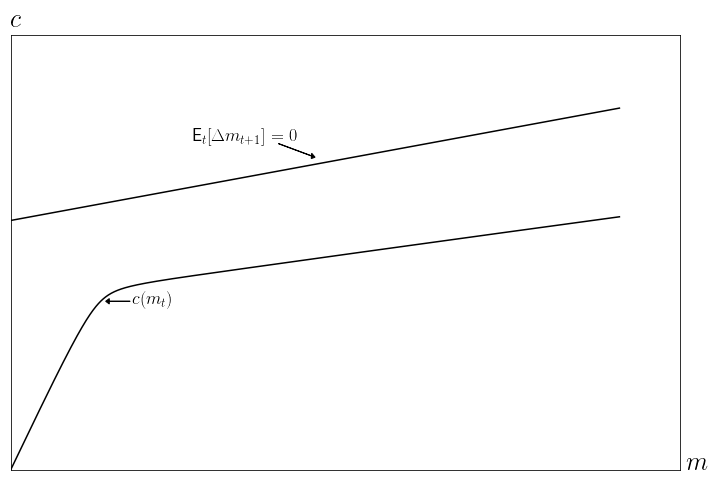

In [13]:
# Plot GICFailExample consumption function against the sustainable level of consumption
GICFailExample.solve() # Above, we set up the problem but did not solve it 
GICFailExample.unpackcFunc()  # Make the consumption function easily accessible for plotting
m = np.linspace(0,5,1000)
c_m = GICFailExample.cFunc[0](m)
E_m = mSSfunc(m)
plt.figure(figsize = (12,8))
plt.plot(m,c_m,color="black")
plt.plot(m,E_m,color="black")
plt.xlim(0,5.5)
plt.ylim(0,1.6)
plt.text(0,1.63,"$c$",fontsize = 26)
plt.text(5.55,0,"$m$",fontsize = 26)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(1,0.6,"$c(m_{t})$",fontsize = 18)
plt.text(1.5,1.2,"$\mathrm{\mathsf{E}}_{t}[\Delta m_{t+1}] = 0$",fontsize = 18)
plt.arrow(0.98,0.62,-0.2,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,1.2,0.3,-0.05,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.svg'))

# This figure reproduces the figure shown in the paper.  
# The gap between the two functions actually increases with $m$ in the limit.
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{baseEx}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type)


In [0]:
# cycles=0 tells the solver to find the infinite horizon solution
baseEx_inf = IndShockConsumerType(cycles=0,**base_params)

baseEx_inf.solve()
baseEx_inf.unpackcFunc()

### [Target $m$, Expected Consumption Growth, and Permanent Income Growth](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisoftheConvergedConsumptionFunction)

The next figure is shown in  [Analysis of the Converged Consumption Function](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cGroTargetFig), which shows the expected consumption growth factor $\mathrm{\mathbb{E}}_{t}[c_{t+1}/c_{t}]$ for a consumer behaving according to the converged consumption rule.


In [0]:
# Define a function to calculate expected consumption 
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption
    Inputs:
       a: end-of-period assets
    Returns:
       expconsump: next period's expected consumption
    '''
    GrowFactp1 = baseEx_inf.PermGroFac[0]* baseEx_inf.PermShkDstn[0][1]
    Rnrmtp1 = baseEx_inf.Rfree / GrowFactp1
    # end-of-period assets plus normalized returns
    btp1 = Rnrmtp1*a
    # expand dims of btp1 and use broadcasted sum of a column and a row vector
    # to obtain a matrix of possible beginning-of-period assets next period
    mtp1 = np.expand_dims(btp1, axis=1) + baseEx_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*baseEx_inf.cFunc[0](mtp1).T
    # finish expectation over permanent income shocks by right multiplying with
    # the weights
    part_expconsumption = np.dot(part_expconsumption, baseEx_inf.PermShkDstn[0][0])
    # finish expectation over transitory income shocks by right multiplying with
    # weights
    expconsumption = np.dot(part_expconsumption, baseEx_inf.TranShkDstn[0][0])
    # return expected consumption
    return expconsumption

In [0]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,baseEx_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = baseEx_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = []
for i in range(len(a1)):
    exp_consumption_tp1 = exp_consumption(a1[i])
    exp_consumption_l1.append(exp_consumption_tp1)

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(baseEx_inf.solution[0].mNrmSS,1.9,50)

c_m2 = baseEx_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = []
for i in range(len(a2)):
    exp_consumption_tp1 = exp_consumption(a2[i])
    exp_consumption_l2.append(exp_consumption_tp1)

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

In [0]:
# Define a function to construct the arrows on the consumption growth rate function
def arrowplot(axes, x, y, narrs=15, dspace=0.5, direc='neg',
              hl=0.01, hw=3, c='black'):
    '''
    The function is used to plot arrows given the data x and y.

    Input:
        narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head

        hw     :  width of the arrow head

        c      :  color of the edge and face of the arrow head
    '''

    # r is the distance spanned between pairs of points
    r = np.sqrt(np.diff(x)**2+np.diff(y)**2)
    r = np.insert(r, 0, 0.0)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = np.cumsum(r)

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace)
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]:
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2.0 + ax
        dy0 = np.cos(theta)*hl/2.0 + ay
        dx1 = -1.*np.sin(theta)*hl/2.0 + ax
        dy1 = -1.*np.cos(theta)*hl/2.0 + ay

        if direc is 'neg' :
            ax0 = dx0
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1
        else:
            ax0 = dx1
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))

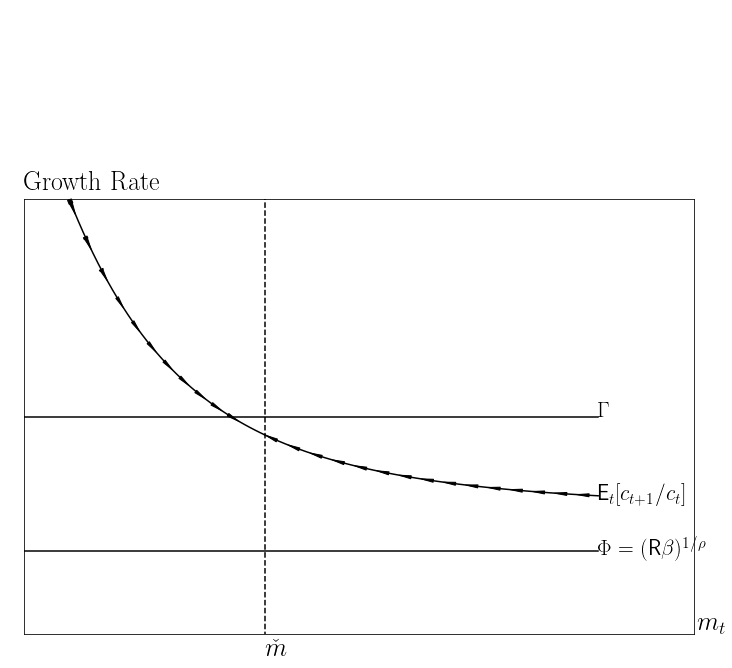

In [18]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[baseEx_inf.PermGroFac[0],baseEx_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
arrowplot(ax, m1,growth1)
arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([baseEx_inf.solution[0].mNrmSS,baseEx_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.05)
ax.set_ylim(0.98,1.08)
ax.text(1,1.082,"Growth Rate",fontsize = 26,fontweight='bold')
ax.text(2.055,0.98,"$m_{t}$",fontsize = 26,fontweight='bold')
ax.text(1.9,1.01,"$\mathrm{\mathsf{E}}_{t}[c_{t+1}/c_{t}]$",fontsize = 22,fontweight='bold')
ax.text(baseEx_inf.solution[0].mNrmSS,0.975, r'$\check{m}$', fontsize = 26,fontweight='bold')
ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
ax.text(1.9,0.998,r'$\Phi = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')
ax.text(1.9,1.03, r'$\Gamma$',fontsize = 22,fontweight='bold')
if Generator:
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.png'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.jpg'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.pdf'))
    fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

### [Consumption Function Bounds](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#AnalysisOfTheConvergedConsumptionFunction)
[The next figure](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)
illustrates theoretical bounds for the consumption function.

We define two useful variables: lower bound of $\kappa$ (the marginal propensity to consume) and limit of $h$ (Human wealth), along with some functions such as limiting perfect foresight consumption functions ($\bar{c}(m)$), $\bar{\bar c}(m)$ and $\underline{c}(m)$.

In [0]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(baseEx_inf.Rfree**(-1.0))*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)
h_inf = (1.0/(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree))
conFunc_PF = lambda m: (h_inf -1)* k_lower + k_lower*m
conFunc_upper = lambda m: (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)*m
conFunc_lower = lambda m: (1 -(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree) * m
intersect_m = ((h_inf-1)* k_lower)/((1 - baseEx_inf.UnempPrb
            **(1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)-k_lower)

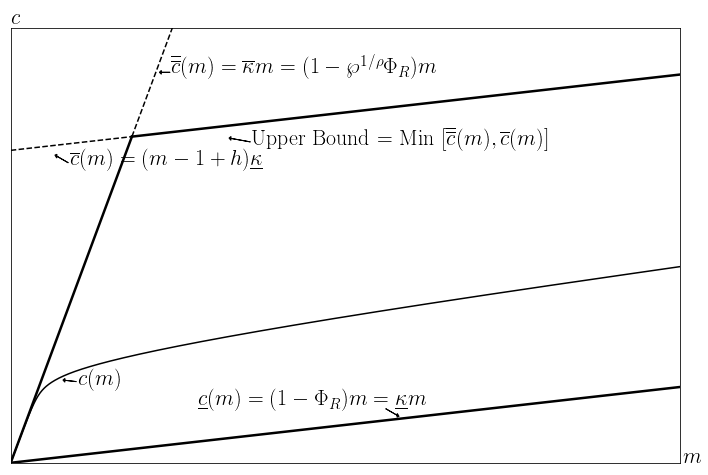

In [20]:
# Plot the consumption function and its bounds
x1 = np.linspace(0,25,1000)
x3 = np.linspace(0,intersect_m,300)
x4 = np.linspace(intersect_m,25,700)
cfunc_m = baseEx_inf.cFunc[0](x1)
cfunc_PF_1 = conFunc_PF(x3)
cfunc_PF_2 = conFunc_PF(x4)
cfunc_upper_1 = conFunc_upper(x3)
cfunc_upper_2 = conFunc_upper(x4)
cfunc_lower = conFunc_lower(x1)
plt.figure(figsize = (12,8))
plt.plot(x1,cfunc_m, color="black")
plt.plot(x1,cfunc_lower, color="black",linewidth=2.5)
plt.plot(x3,cfunc_upper_1, color="black",linewidth=2.5)
plt.plot(x4,cfunc_PF_2 , color="black",linewidth=2.5)
plt.plot(x4,cfunc_upper_2 , color="black",linestyle="--")
plt.plot(x3,cfunc_PF_1 , color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.xlim(0,25)
plt.ylim(0,1.12*conFunc_PF(25))
plt.text(0,1.12*conFunc_PF(25)+0.05,"$c$",fontsize = 22)
plt.text(25+0.1,0,"$m$",fontsize = 22)
plt.text(2.5,1,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.text(6,5,r'$\overline{\overline{c}}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\Phi_{R})m$',fontsize = 22,fontweight='bold')
plt.text(2.2,3.8, r'$\overline{c}(m) = (m-1+h)\underline{\kappa}$',fontsize = 22,fontweight='bold')
plt.text(9,4.1,r'Upper Bound $ = $ Min $[\overline{\overline{c}}(m),\overline{c}(m)]$',fontsize = 22,fontweight='bold')
plt.text(7,0.7,r'$\underline{c}(m)= (1-\Phi_{R})m = \underline{\kappa}m$',fontsize = 22,fontweight='bold')
plt.arrow(2.45,1.05,-0.5,0.02,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.15,3.88,-0.5,0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(8.95,4.15,-0.8,0.05,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,5.05,-0.4,0,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(14,0.70,0.5,-0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

### [The Consumption Function and Target $m$](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#cFuncBounds)

This figure shows the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ and consumption function $c(m_{t})$, along with the intrsection of these two functions, which defines the target value of $m$

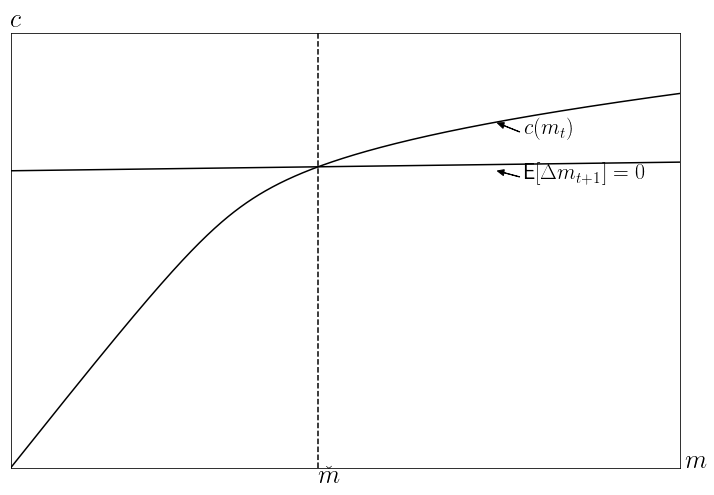

In [21]:
# This just plots objects that have already been constructed

m1 = np.linspace(0,4,1000)
cfunc_m = baseEx_inf.cFunc[0](m1)
mSSfunc = lambda m:(baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)+(1.0-baseEx_inf.PermGroFac[0]/baseEx_inf.Rfree)*m
mss = mSSfunc(m1)
plt.figure(figsize = (12,8))
plt.plot(m1,cfunc_m, color="black")
plt.plot(m1,mss, color="black")
plt.xlim(0,3)
plt.ylim(0,1.45)
plt.plot([baseEx_inf.solution[0].mNrmSS, baseEx_inf.solution[0].mNrmSS],[0,2.5],color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,1.47,r"$c$",fontsize = 26)
plt.text(3.02,0,r"$m$",fontsize = 26)
plt.text(2.3,0.95,r'$\mathrm{\mathsf{E}}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
plt.text(2.3,1.1,r"$c(m_{t})$",fontsize = 22,fontweight='bold')
plt.text(baseEx_inf.solution[0].mNrmSS,-0.05, r"$\check{m}$",fontsize = 26)
plt.arrow(2.28,1.12,-0.1,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.28,0.97,-0.1,0.02,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.svg'))

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining $\underline{\kappa}$ as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = \underline{\kappa}$.  

The paper also derives an analytical limit $\bar{\kappa}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\kappa}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

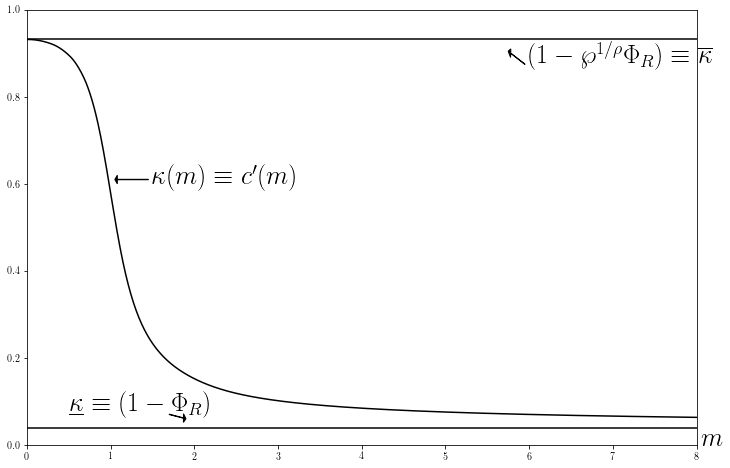

In [22]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = baseEx_inf.cFunc[0].derivative(m)

# Define the upper bound of MPC
MPCUpper = (1 - baseEx_inf.UnempPrb ** (1.0/baseEx_inf.CRRA)*(baseEx_inf.Rfree*baseEx_inf.DiscFac)**(1.0/baseEx_inf.CRRA)/baseEx_inf.Rfree)

# Define the lower bound of MPC
MPCLower = k_lower

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCUpper,MPCUpper],color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
plt.text(6,0.87,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold')
plt.text(0.5,0.07,r'$\underline{\kappa}\equiv(1-\Phi_{R})$',fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(1.7,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,0.875,-0.2,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted

# Summary

[Two tables in the paper](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Sufficient-Conditions-For-Nondegenerate-Solution) summarize the various definitions, and then articulate conditions required for the problem to have a nondegenerate solution.

The main other contribution of the paper is to show that, under parametric combinations where the solution is nondegenerate, if the Growth Impatience Condition holds there will be a target level of wealth.